# Develop the VircamISRTask
We need to develop a new ISR task to implement the confidence maps in the variance plane

In [1]:
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import numpy as np

In [3]:
from lsst import utils

In [7]:
from lsst.utils import getPackageDir

In [ ]:
utils.

In [5]:
from lsst.utils.introspection import get_full_type_name

ModuleNotFoundError: No module named 'lsst.utils.introspection'

In [4]:
from lsst.utils.introspection import get_full_type_name

ModuleNotFoundError: No module named 'lsst.utils.introspection'

In [80]:
# For DC2 gen3, these are the only optoins
repo = './data'
collection = 'videoTest'

# Use the butler to get the calexp
butler = Butler(repo)


registry = butler.registry
for c in sorted(registry.queryCollections()):
    print(c)

VIRCAM/calib
VIRCAM/calib/unbounded
VIRCAM/raw/all
confidence
refcats
skymaps
videoTest


In [81]:
# Define the dataId
dataId = {'instrument':'VIRCAM','filter': 'K', 'exposure': 658653, 'detector': 9}
butler = Butler(repo, collections='VIRCAM/raw/all')
ccdExposure = butler.get('raw', **dataId)

Ignoring Error calculating property 'temperature' using translator <class 'lsst.obs.vista.translators.vircam.VircamTranslator'> and file /Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/VIRCAM/raw/all/raw/20121123/658653/raw_VIRCAM_VIRCAM-Ks_658653_ccd1_VIRCAM_raw_all.fit: 'ESO INS THERMAL AMB MEAN not found'
Ignoring Error calculating property 'altaz_begin' using translator <class 'lsst.obs.vista.translators.vircam.VircamTranslator'> and file /Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/VIRCAM/raw/all/raw/20121123/658653/raw_VIRCAM_VIRCAM-Ks_658653_ccd1_VIRCAM_raw_all.fit: '/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/VIRCAM/raw/all/raw/20121123/658653/raw_VIRCAM_VIRCAM-Ks_658653_ccd1_VIRCAM_raw_all.fit(658653): Unable to determine AltAz of science observation'


detectorId 9 type <class 'int'>
detectorId 9 type <class 'int'>


In [84]:
# Define the dataId
dataId = {'instrument':'VIRCAM','filter': 'K', 'visit': 658653, 'detector': 9}
butler = Butler(repo, collections='videoTest')
confidence = butler.get('confidence3', **dataId)

Ignoring Error calculating property 'temperature' using translator <class 'lsst.obs.vista.translators.vircam.VircamTranslator'> and file /Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/videoTest/confidence3/20121123/K/VIRCAM-Ks/658653/confidence3_VIRCAM_K_VIRCAM-Ks_658653_ccd9_videoTest.fit: 'ESO INS THERMAL AMB MEAN not found'
Ignoring Error calculating property 'altaz_begin' using translator <class 'lsst.obs.vista.translators.vircam.VircamTranslator'> and file /Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/videoTest/confidence3/20121123/K/VIRCAM-Ks/658653/confidence3_VIRCAM_K_VIRCAM-Ks_658653_ccd9_videoTest.fit: '/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/videoTest/confidence3/20121123/K/VIRCAM-Ks/658653/confidence3_VIRCAM_K_VIRCAM-Ks_658653_ccd9_videoTest.fit(658653): Unable to determine AltAz of science observation'


detectorId 9 type <class 'int'>
detectorId 9 type <class 'int'>


In [128]:
from lsst.ip.isr import isrFunctions
def updateVarianceFixedGain(test):
    print(test)
isrFunctions.updateVariance = updateVarianceFixedGain
isrFunctions.updateVariance('It worked')

It worked


In [124]:
#imports required by task definition - this cell should contain all the Python for the task 
#such that it can be directly copied to obs_vista/python/lsst/obs/vista/vircamIsrTask.py
from lsst.ip.isr.isrTask import IsrTask, IsrTaskConfig
import lsst.pex.config as pexConfig
import lsst.pipe.base as pipeBase
from lsst.utils.timer import timeMethod

__all__ = ["VircamIsrConfig", "VircamIsrTask"]


class VircamIsrConfig(IsrTaskConfig):
    doConfidence = pexConfig.Field(
        dtype=bool,
        doc="Apply the CASU VISTA confidence map to the exposure variance image if available.",
        default=False,
    )


class VircamIsrTask(IsrTask):
    """Load a CASU confidence map and apply it to the variance plane

    This is used to retarget the `isr` subtask in `ProcessCcdTask` when you prefer to use
    the community pipeline instead of the LSST software stack to perform ISR on DECam images.
    """
    ConfigClass = VircamIsrConfig
    _DefaultName = "isr"

    def applyConfidenceMapToAmpExposure(self, ampExposure, confMap=None):
        """Return variance plane for image given confidence map
        
        
        """
        print("applyConfidenceMapToAmpExposure called")
        if confMap is not None:
            maskedImage = ampExposure.getMaskedImage()  
            var = maskedImage.getVariance()
            var *= 100./confMap

    @timeMethod
    def updateVariance(self, ampExposure, amp, overscanImage=None, ptcDataset=None):
        """Find the confidence map and modify the ampExposure sent to the variance method

        """
        #self.log.info("Loading VISTA community pipeline file %s" % (sensorRef.dataId))
        #get exposure number and update gain
        expNum=ampExposure.getInfo().getMetadata().getAsInt('ESO DET NDIT')
        print("expNum:{}".format(expNum))
        global gain, ampGlob
        ampGlob=amp
        gain=amp.getGain()
        print("gain:{}".format(gain))
        gain*=(expNum/10) #6 is default value set in camera
        print("gain:{},{}".format(gain,amp.getGain()))
        #multiple variance by 100/conf map if requested
        print("self.config.doConfidence:",self.config.doConfidence)
        super().updateVariance(ampExposure, amp, overscanImage=overscanImage, ptcDataset=ptcDataset)
        print("updateVariance ran")
        if self.config.doConfidence:
            print("Running confidence")
            try:
                # get the confidence map using the dataRef for the exposure
                confMap = dataRef.get("confMap", immediate=True)
                applyConfidenceMapToAmpExposure(self, ampExposure, confMap=confMap)
                self.log.info("Confidence map applied to variance plane." )
            except: #NoResults from gen3 Butler?
                confMap = None
                self.log.info("Confidence map not found in Butler." )
                print("Confidence map not found in Butler." )
        else:
            self.log.info("Variance plane set without application of confidence map." )
            
        if self.confidence.doGainRenormalization:
            
    @timeMethod
    def runDataRef(self, sensorRef):
        """Perform instrument signature removal on a ButlerDataRef of a Sensor.
        This method contains the `CmdLineTask` interface to the ISR
        processing.  All IO is handled here, freeing the `run()` method
        to manage only pixel-level calculations.  The steps performed
        are:
        - Read in necessary detrending/isr/calibration data.
        - Process raw exposure in `run()`.
        - Persist the ISR-corrected exposure as "postISRCCD" if
          config.doWrite=True.
        Parameters
        ----------
        sensorRef : `daf.persistence.butlerSubset.ButlerDataRef`
            DataRef of the detector data to be processed
        Returns
        -------
        result : `lsst.pipe.base.Struct`
            Result struct with component:
            - ``exposure`` : `afw.image.Exposure`
                The fully ISR corrected exposure.
        Raises
        ------
        RuntimeError
            Raised if a configuration option is set to True, but the
            required calibration data does not exist.
        """
        self.log.info("Performing ISR on sensor %s.", sensorRef.dataId)
        print("Performing ISR on sensor %s.", sensorRef.dataId)
        ccdExposure = sensorRef.get(self.config.datasetType)

        camera = sensorRef.get("camera")
        isrData = self.readIsrData(sensorRef, ccdExposure)
        print("isrData.getDict():{}".format(isrData.getDict()))
        result = self.run(ccdExposure, camera=camera, **isrData.getDict())

        if self.config.doWrite:
            sensorRef.put(result.exposure, "postISRCCD")
            if result.preInterpExposure is not None:
                sensorRef.put(result.preInterpExposure, "postISRCCD_uninterpolated")
        if result.ossThumb is not None:
            isrQa.writeThumbnail(sensorRef, result.ossThumb, "ossThumb")
        if result.flattenedThumb is not None:
            isrQa.writeThumbnail(sensorRef, result.flattenedThumb, "flattenedThumb")

        return result
    

config = VircamIsrTask.ConfigClass()
config.doBias=False
config.doDark=False
config.doFlat=False
config.doDefect=False
config.doConfidence=True
VircamIsrTaskInstance = VircamIsrTask(config=config)
result = VircamIsrTaskInstance.run(ccdExposure)

expNum:6
gain:31.71
gain:27.18,31.71
self.config.doConfidence: True
updateVariance ran
Running confidence
Confidence map not found in Butler.


No rough magnitude zero point defined for filter VIRCAM-Ks.


In [126]:
ampGlob.

In [112]:
dataId = {'instrument':'VIRCAM','filter': 'K', 'visit': 658653, 'detector': 9}
butler = Butler(repo, collections='videoTest')
confidence = butler.get('confidence3', **dataId)
ccdExposure.

lsst.afw.image.ExposureInfo

In [ ]:
butler.

In [ ]:
result = VircamIsrTaskInstance.runDataRef()

In [88]:
c=confidence.getMaskedImage()
c.getImage().array.shape

(2127, 2106)

In [59]:
maskedImage=ccdExposure.getMaskedImage()
var=maskedImage.getVariance()


In [78]:
ccdExposure.getInfo().getMetadata().getAsInt('ESO DET NDIT')

6

In [34]:
config = IsrTask.ConfigClass()
config.doBias=False
config.doDark=False
config.doFlat=False
config.doDefect=False
IsrTaskInstance = IsrTask(config=config)
result = IsrTaskInstance.run(ccdExposure)

No rough magnitude zero point defined for filter VIRCAM-Ks.


In [93]:
config = VircamIsrTask.ConfigClass()
config.doBias=False
config.doDark=False
config.doFlat=False
config.doDefect=False
config.doConfidence=True
VircamIsrTaskInstance = VircamIsrTask(config=config)
result = VircamIsrTaskInstance.run(ccdExposure)

TypeError: updateVariance() got multiple values for argument 'overscanImage'

In [35]:
result

Struct(exposure=<lsst.afw.image.exposure.ExposureF object at 0x7ff8391409f0>; ossThumb=None; flattenedThumb=None; preInterpExposure=None; outputExposure=<lsst.afw.image.exposure.ExposureF object at 0x7ff8391409f0>; outputOssThumbnail=None; outputFlattenedThumbnail=None)

In [37]:
out=result.outputExposure

In [38]:
out.getVariance()

lsst.afw.image.image.ImageF=[[3.5408572e+02 3.5398044e+02 3.5402814e+02 ... 3.5430624e+02
  3.5393674e+02 3.5377829e+02]
 [3.5368842e+02 3.5351163e+02 3.5385132e+02 ... 3.5333682e+02
  3.5390894e+02 3.5415427e+02]
 [3.5382947e+02 3.5404599e+02 3.5412149e+02 ... 3.5397052e+02
  3.5349573e+02 3.5329214e+02]
 ...
 [3.5422879e+02 3.5469363e+02 3.5389902e+02 ... 3.5404599e+02
  3.5404599e+02 3.5404599e+02]
 [3.5404599e+02 3.5404599e+02 3.5404599e+02 ... 3.5404599e+02
  3.5404599e+02 3.5404599e+02]
 [1.3290007e-01 1.3290007e-01 1.3290007e-01 ... 1.3290007e-01
  1.3290007e-01 1.3290007e-01]], bbox=(minimum=(0, 0), maximum=(2048, 2048))

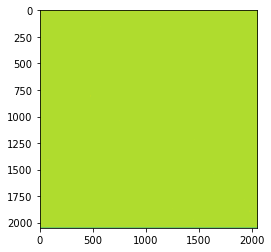

In [52]:
plt.imshow(np.log(out.getVariance().array))

(array([15806., 16861., 13591., 18523., 14797., 20408., 21830., 17189.,
        23775., 18739., 26188., 27533., 21294., 29911., 23678., 32753.,
        33739., 26807., 36303., 28225., 39299., 30343., 41548., 43076.,
        33672., 45362., 35413., 47558., 49483., 38303., 51876., 40363.,
        52993., 55123., 41824., 56770., 44206., 59333., 44738., 60055.,
        61148., 46635., 61595., 46794., 61962., 62832., 47681., 63486.,
        47420., 66229., 63043., 47695., 63034., 47619., 63163., 60706.,
        45981., 60455., 45165., 58329., 44117., 57418., 56517., 41721.,
        54467., 40434., 52671., 50758., 37853., 48358., 36087., 46460.,
        44963., 32508., 42001., 30759., 39878., 38542., 27624., 36012.,
        26446., 33288., 23941., 30959., 29890., 21070., 27011., 19595.,
        25016., 23498., 17028., 21709., 15402., 19563., 18178., 13053.,
        16575., 11932., 15048., 14206.]),
 array([353.69635, 353.7035 , 353.7106 , 353.71774, 353.72488, 353.732  ,
        353.73914, 3

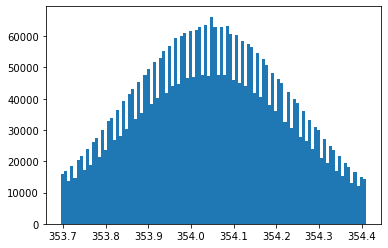

In [51]:
plt.hist(out.getVariance().array.flatten(),bins=100,
         range=[np.percentile(out.getVariance().array.flatten(),5),np.percentile(out.getVariance().array.flatten(),95)]
        )